 # PROYECTO 2
 ----
  
  University : UTEC \\
  Course       : Machine Learning \\
  Professor    : Cristian López Del Alamo \\
  Topic        : Proyecto 2 \\
  

 ----

Write the names and surnames of the members and the percentage of participation of each one in the development of the practice:
 - Integrante 1: Luis Carbajal (100%)
 - Integrante 2: Diana Ñañez (100%)
 - Integrante 3: Leandro Machaca Soloaga(100%)



 ----

### Importamos las librerias necesarias para el Poryecto

In [55]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cvxopt import matrix, solvers
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pyts.transformation import ROCKET
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from queue import PriorityQueue
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score


### Funcion para cargar la data

In [56]:
def load_h5_to_dataframe(file_path):
    with h5py.File(file_path, "r") as f:
    
        dataframes = []
        for key in list(f.keys()):
            
            dataset = np.array(f[key])
            
            if dataset.ndim > 1:
                num_features = dataset.shape[1]
                columns = [f"{key}_{i}" for i in range(num_features)]
                df = pd.DataFrame(dataset, columns=columns)
            else:
                df = pd.DataFrame(dataset, columns=[key])
            
            dataframes.append(df)
        
        combined_df = pd.concat(dataframes, axis=1)
        return combined_df



In [57]:
train_path = 'train.h5'
test_path = 'test.h5'

train_data = load_h5_to_dataframe(train_path)
test_data = load_h5_to_dataframe(test_path)

## Preprocesamiento

#### Realizamos las diviciones de X_train en 70% (train) y 30% (test)

In [58]:

X = train_data.drop(columns=['y'])
Y = train_data['y']


X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=104, test_size=0.30, shuffle=True)



#### Aplicamos el metodo ROCKET para extraer las caracteriticas de la serie temporal

Elegimos este metodo por su rapidez y alta eficacia en la mayoria de casos

In [59]:
rocket = ROCKET()
X_train_rocket = rocket.fit_transform(X_train)
X_test_rocket = rocket.transform(X_test)

### Estandarizamos los datos

In [60]:
scaler = StandardScaler()
X_train_rocket = scaler.fit_transform(X_train_rocket)
X_test_rocket = scaler.transform(X_test_rocket)

#### Aplicamos PCA para reducir la dimensionalidad

Obtenemos el mejor numero de componentes ayudandonos de un analisis de la varianza

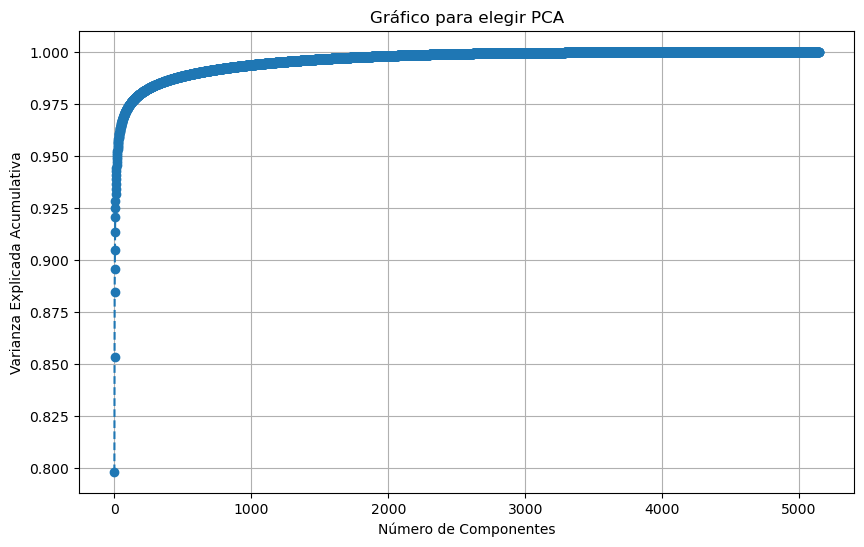

In [61]:

pca = PCA().fit(X_train_rocket)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(explained_variance, marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulativa')
plt.title('Gráfico para elegir PCA')
plt.grid(True)
plt.show()

Elegimos 21 componentes para realizar la reduccion de dimensionalidad, ya que estos explican mas del 95% de la varianza

In [62]:

n_components = np.argmax(explained_variance >= 0.95) + 1

pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_rocket)
X_test_pca = pca.transform(X_test_rocket)

print(f'Mejor numero de componentes: {n_components}')

Mejor numero de componentes: 21


## Aplicacion de librerias
Utilizamos librerias para aplicar los modelos Regresion Logistica y SVM para verificar el correcto preprocesamiento y ver que modelo se adapta mejor a nustros datos

### Regresion logistica

Modelo Usado: Regresión Logística:
Resultado del Accuracy: 0.9360834088848595
Resultado del F1-Score: 0.9360593630039455
Reporte del Modelo:
               precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       369
         2.0       0.95      0.95      0.95       337
         3.0       0.93      0.94      0.94       285
         4.0       0.89      0.87      0.88       385
         5.0       0.88      0.90      0.89       402
         6.0       1.00      1.00      1.00       428

    accuracy                           0.94      2206
   macro avg       0.94      0.94      0.94      2206
weighted avg       0.94      0.94      0.94      2206





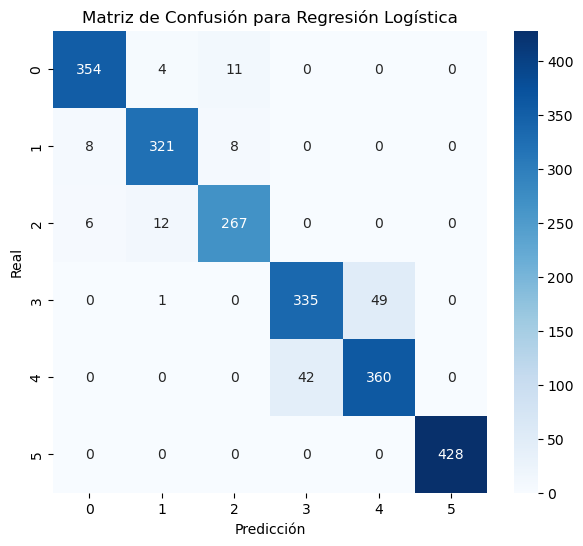

In [63]:

logistic_regression = LogisticRegression(max_iter=10000)


logistic_regression.fit(X_train_pca, y_train)
y_pred_logistic = logistic_regression.predict(X_test_pca)

accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
f1_logistic = f1_score(y_test, y_pred_logistic, average='weighted')
cm_logistic = confusion_matrix(y_test, y_pred_logistic)


print("Modelo Usado: Regresión Logística:")
print("Resultado del Accuracy:", accuracy_logistic)
print("Resultado del F1-Score:", f1_logistic)
print("Reporte del Modelo:\n", classification_report(y_test, y_pred_logistic))
print("\n")


plt.figure(figsize=(7, 6))
sns.heatmap(cm_logistic, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión para Regresión Logística')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


### SVM

Modelo Usado: SVM:
Resultado del Accuracy: 0.9378966455122394
Resultado del F1-Score: 0.9378286782635699
Reporte del Modelo:
               precision    recall  f1-score   support

         1.0       0.95      0.98      0.97       369
         2.0       0.97      0.93      0.95       337
         3.0       0.93      0.95      0.94       285
         4.0       0.90      0.86      0.88       385
         5.0       0.87      0.91      0.89       402
         6.0       1.00      1.00      1.00       428

    accuracy                           0.94      2206
   macro avg       0.94      0.94      0.94      2206
weighted avg       0.94      0.94      0.94      2206





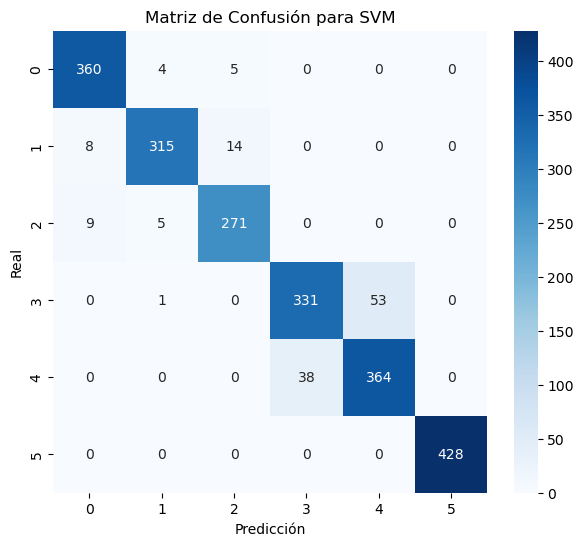

In [64]:

svm = SVC()

svm.fit(X_train_pca, y_train)
y_pred_svm_libreria = svm.predict(X_test_pca)


accuracy_svm_libreria = accuracy_score(y_test, y_pred_svm_libreria)
f1_svm = f1_score(y_test, y_pred_svm_libreria, average='weighted')
cm_svm_libreria = confusion_matrix(y_test, y_pred_svm_libreria)


print("Modelo Usado: SVM:")
print("Resultado del Accuracy:", accuracy_svm_libreria)
print("Resultado del F1-Score:", f1_svm)
print("Reporte del Modelo:\n", classification_report(y_test, y_pred_svm_libreria))
print("\n")


plt.figure(figsize=(7, 6))
sns.heatmap(cm_svm_libreria, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión para SVM')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

## Implementacion

Ahora implementaremos los modelos Arbol de Desicion y KNN para luego realizar la comparacion de Scores

### Arbol de desicion

In [65]:
class Nodo:
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.label = None
        self.feature_index = None
        self.threshold = None
        self.izquierda = None
        self.derecha = None

    def IsTerminal(self):
        return len(np.unique(self.Y)) == 1

    def entropy(self):
        _, counts = np.unique(self.Y, return_counts=True)
        probabilities = counts / len(self.Y)
        entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))
        return entropy

    def information_gain(self, left_Y, right_Y):
        parent_entropy = self.entropy()
        left_entropy = self.entropy_array(left_Y)
        right_entropy = self.entropy_array(right_Y)
        total_samples = len(self.Y)
        
        info_gain = parent_entropy - (
            (len(left_Y) / total_samples) * left_entropy +
            (len(right_Y) / total_samples) * right_entropy
        )
        return info_gain

    def entropy_array(self, Y):
        _, counts = np.unique(Y, return_counts=True)
        probabilities = counts / len(Y)
        entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))
        return entropy

    def BestSplit(self):
        best_feature_index = None
        best_threshold = None
        best_info_gain = -1

        for feature_index in range(self.X.shape[1]):
            unique_values = np.unique(self.X[:, feature_index])
            for i in range(len(unique_values) - 1):
                threshold = (unique_values[i] + unique_values[i + 1]) / 2
                left_mask = self.X[:, feature_index] <= threshold
                right_mask = ~left_mask
                info_gain = self.information_gain(self.Y[left_mask], self.Y[right_mask])
                if info_gain > best_info_gain:
                    best_info_gain = info_gain
                    best_feature_index = feature_index
                    best_threshold = threshold

        return best_feature_index, best_threshold

class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, Y):
        self.root = self._create_tree(X, Y, depth=0)

    def _create_tree(self, X, Y, depth):
        node = Nodo(X, Y)

        if node.IsTerminal() or (self.max_depth and depth == self.max_depth):
            node.label = np.argmax(np.bincount(Y))
            return node

        feature_index, threshold = node.BestSplit()
        if feature_index is None:
            node.label = np.argmax(np.bincount(Y))
            return node

        node.feature_index = feature_index
        node.threshold = threshold

        left_mask = X[:, feature_index] <= threshold
        right_mask = ~left_mask

        node.izquierda = self._create_tree(X[left_mask], Y[left_mask], depth + 1)
        node.derecha = self._create_tree(X[right_mask], Y[right_mask], depth + 1)

        return node

    def predict(self, X):
        return np.array([self._predict_sample(sample, self.root) for sample in X])

    def _predict_sample(self, sample, node):
        if node.label is not None:
            return node.label

        if sample[node.feature_index] <= node.threshold:
            return self._predict_sample(sample, node.izquierda)
        else:
            return self._predict_sample(sample, node.derecha)

#### Entrenamiento y testing del Arbol de Desicion

Exactitud: 0.9075249320036265
F1 Score: 0.9073851623496456
Matriz de Confusión:
[[328  28  13   0   0   0]
 [ 21 277  38   0   0   1]
 [ 19   9 257   0   0   0]
 [  0   1   0 340  42   2]
 [  0   0   0  28 374   0]
 [  0   0   0   1   1 426]]


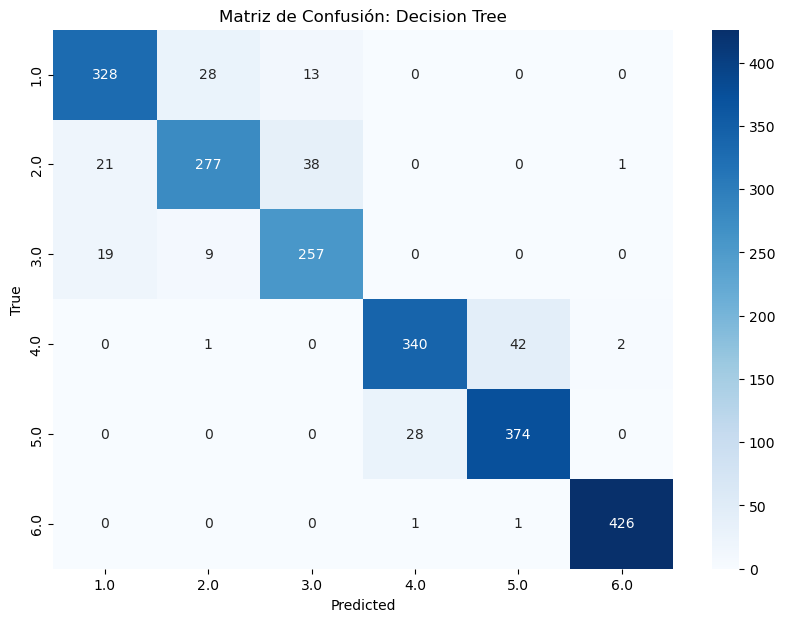

              precision    recall  f1-score   support

         1.0       0.89      0.89      0.89       369
         2.0       0.88      0.82      0.85       337
         3.0       0.83      0.90      0.87       285
         4.0       0.92      0.88      0.90       385
         5.0       0.90      0.93      0.91       402
         6.0       0.99      1.00      0.99       428

    accuracy                           0.91      2206
   macro avg       0.90      0.90      0.90      2206
weighted avg       0.91      0.91      0.91      2206



In [66]:

dt = DecisionTree(max_depth=10)  
dt.fit(X_train_pca, y_train)


y_pred_arbol = dt.predict(X_test_pca)

accuracy_arbol = accuracy_score(y_test, y_pred_arbol)
f1_arbol = f1_score(y_test, y_pred_arbol, average='weighted')
cm_arbol = confusion_matrix(y_test, y_pred_arbol)

print(f"Exactitud: {accuracy_arbol}")
print(f"F1 Score: {f1_arbol}")
print("Matriz de Confusión:")
print(cm_arbol)


plt.figure(figsize=(10, 7))
sns.heatmap(cm_arbol, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión: Decision Tree')
plt.show()

print(classification_report(y_test, y_pred_arbol))

### KNN

In [67]:

def knn(p, X, k):
    k_dist = PriorityQueue(k)
    for i in range(len(X)):
        dist = np.linalg.norm(X[i] - p)
        if not k_dist.full():
            k_dist.put((-dist, i))
        else:
            least_min = k_dist.get()
            if dist < abs(least_min[0]):
                k_dist.put((-dist, i))
            else:
                k_dist.put(least_min)
    return k_dist


def train_knn(X, k, X_train, Y_train):
    Y = list(Y_train)
    y_pred = []
    for p in X:
        k_elem = knn(p, X_train, k)
        y_temp = []
        while not k_elem.empty():
            idx = k_elem.get()[1]
            y_temp.append(Y[idx])
        y_pred.append(max(set(y_temp), key = y_temp.count))
    return y_pred

In [68]:

accuracy = []
for k in range(10):
    y_pred = train_knn(X_test_pca, k+1, X_train_pca, y_train)
    accuracy.append(accuracy_score(y_test, y_pred))

best_k = np.argmax(accuracy) + 1
print('Mejor k: ', best_k)
print('Resultado del Accuracy:', accuracy[best_k-1])
print(accuracy)

Mejor k:  1
Resultado del Accuracy: 0.956935630099728
[0.956935630099728, 0.9451495920217589, 0.9514959202175884, 0.9514959202175884, 0.9528558476881233, 0.9469628286491387, 0.9483227561196736, 0.9446962828649139, 0.9442429737080689, 0.942429737080689]


Modelo Usado: KNN
Exactitud: 0.956935630099728
F1 Score: 0.9568850807573023
Matriz de Confusión:
[[356   5   8   0   0   0]
 [ 12 320   5   0   0   0]
 [ 12  13 260   0   0   0]
 [  0   1   0 364  20   0]
 [  0   0   0  19 383   0]
 [  0   0   0   0   0 428]]


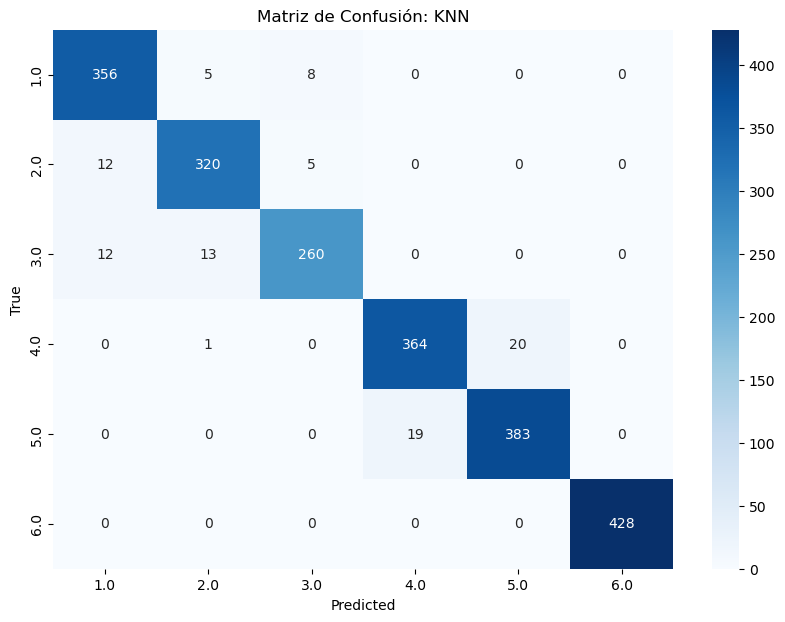

              precision    recall  f1-score   support

         1.0       0.94      0.96      0.95       369
         2.0       0.94      0.95      0.95       337
         3.0       0.95      0.91      0.93       285
         4.0       0.95      0.95      0.95       385
         5.0       0.95      0.95      0.95       402
         6.0       1.00      1.00      1.00       428

    accuracy                           0.96      2206
   macro avg       0.96      0.95      0.95      2206
weighted avg       0.96      0.96      0.96      2206



In [69]:
y_pred_knn = train_knn(X_test_pca, best_k, X_train_pca, y_train)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')
cm_knn = confusion_matrix(y_test, y_pred_knn)

print(f"Modelo Usado: KNN")
print(f"Exactitud: {accuracy_knn}")
print(f"F1 Score: {f1_knn}")
print("Matriz de Confusión:")
print(cm_knn)

# Graficar la Matriz de Confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión: KNN')
plt.show()

print(classification_report(y_test, y_pred_knn))

## testing

#### preparacion de la data para el testing

In [70]:

X_test_data_rocket = rocket.transform(test_data)

X_test_data_scaled = scaler.transform(X_test_data_rocket)

X_test_data_pca = pca.transform(X_test_data_scaled)



### testing del Arbol de decicion

In [71]:
predictions_arbol = dt.predict(X_test_data_pca)

indices = np.arange(1, len(predictions_arbol) + 1)
results_arbol = pd.DataFrame({'index': indices, 'prediction': predictions_arbol})

results_arbol.to_csv('predicciones_arbol.csv', index=False, header=False)

### Testing del KNN

In [72]:

predictions_knn = train_knn(X_test_data_pca, best_k, X_train_pca, y_train)

indices = np.arange(1, len(predictions_knn) + 1)
results_knn = pd.DataFrame({'index': indices, 'prediction': predictions_knn})

results_knn.to_csv('predicciones_knn.csv', index=False, header=False)